In [1]:
import sys
print(sys.executable)



/Library/Developer/CommandLineTools/usr/bin/python3


In [2]:
import geopandas as gpd
print(gpd.__version__)


1.0.1


IMPORTS

In [3]:
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from PIL import Image

import geopandas as gpd
import contextily as ctx

plt.style.use("seaborn-v0_8")
sns.set_context("talk")


/Users/khushirawat/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


PATH SETUP

In [4]:
PROJECT_ROOT = Path(".").resolve()

DATA_DIR = PROJECT_ROOT / "data"
IMAGE_DIR = DATA_DIR / "images"
PROCESSED_DIR = DATA_DIR / "processed"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

print("Images directory:", IMAGE_DIR)


Images directory: /Users/khushirawat/Desktop/CDC/data/images


LOAD TRAINING DATA

In [5]:
train_df = pd.read_csv("train(1)(train(1)).csv")

print("Train shape:", train_df.shape)
train_df.head()


Train shape: (16209, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,9117000170,20150505T000000,268643,4,2.25,1810,9240,2.0,0,0,...,7,1810,0,1961,0,98055,47.4362,-122.187,1660,9240
1,6700390210,20140708T000000,245000,3,2.50,1600,2788,2.0,0,0,...,7,1600,0,1992,0,98031,47.4034,-122.187,1720,3605
2,7212660540,20150115T000000,200000,4,2.50,1720,8638,2.0,0,0,...,8,1720,0,1994,0,98003,47.2704,-122.313,1870,7455
3,8562780200,20150427T000000,352499,2,2.25,1240,705,2.0,0,0,...,7,1150,90,2009,0,98027,47.5321,-122.073,1240,750
4,7760400350,20141205T000000,232000,3,2.00,1280,13356,1.0,0,0,...,7,1280,0,1994,0,98042,47.3715,-122.074,1590,8071


In [6]:
train_df.shape


(16209, 21)

DEFINE KEY COLUMNS

In [7]:
TARGET_COL = "price"
LAT_COL = "lat"
LON_COL = "long"


CREATE IMAGE PATH COLUMN

In [8]:
train_df["image_path"] = train_df.index.map(
    lambda x: IMAGE_DIR / f"{x}.png"
)

train_df[["lat", "long", "image_path"]].head()


,lat,long,image_path
0,47.4362,-122.187,/Users/khushirawat/Desktop/CDC/data/images/0.png
1,47.4034,-122.187,/Users/khushirawat/Desktop/CDC/data/images/1.png
2,47.2704,-122.313,/Users/khushirawat/Desktop/CDC/data/images/2.png
3,47.5321,-122.073,/Users/khushirawat/Desktop/CDC/data/images/3.png
4,47.3715,-122.074,/Users/khushirawat/Desktop/CDC/data/images/4.png


VERIFY IMAGE COVERAGE

In [9]:
train_df["image_exists"] = train_df["image_path"].apply(lambda p: p.exists())

coverage = train_df["image_exists"].mean()
print(f"Image coverage: {coverage:.2%}")



Image coverage: 100.00%


LOG-PRICE TRANSFORMATION

In [10]:
train_df["log_price"] = np.log1p(train_df[TARGET_COL])

train_df[[TARGET_COL, "log_price"]].describe().T



,count,mean,std,min,25%,50%,75%,max
price,16209.0,537470.282744,360303.577357,75000.000000,320000.000000,450000.000000,640000.000000,7.700000e+06
log_price,16209.0,13.045201,0.523880,11.225257,12.676079,13.017005,13.369225,1.585673e+01


In [11]:
train_df.isna().mean().sort_values(ascending=False).head(10)


id               0.0
date             0.0
image_exists     0.0
image_path       0.0
sqft_lot15       0.0
sqft_living15    0.0
long             0.0
lat              0.0
zipcode          0.0
yr_renovated     0.0
dtype: float64

In [12]:
train_df[[LAT_COL, LON_COL]].describe()


,lat,long
count,16209.000000,16209.000000
mean,47.560707,-122.214003
std,0.138340,0.140093
min,47.159300,-122.519000
25%,47.472500,-122.328000
50%,47.572400,-122.230000
75%,47.678200,-122.125000
max,47.777600,-121.315000


TABULAR EDA

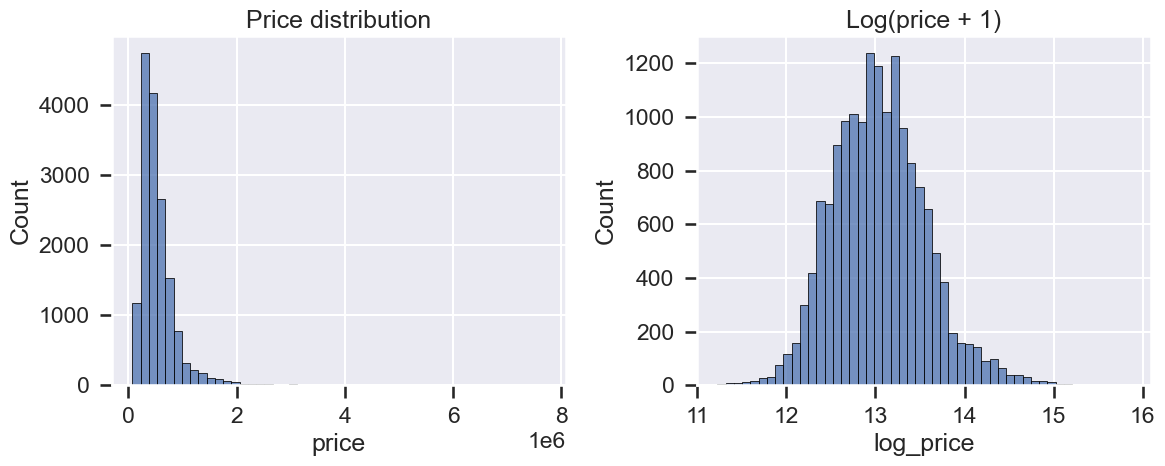

In [13]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(train_df[TARGET_COL], bins=50)
plt.title("Price distribution")

plt.subplot(1,2,2)
sns.histplot(train_df["log_price"], bins=50)
plt.title("Log(price + 1)")

plt.tight_layout()
plt.show()


GEOSPATIAL EDA

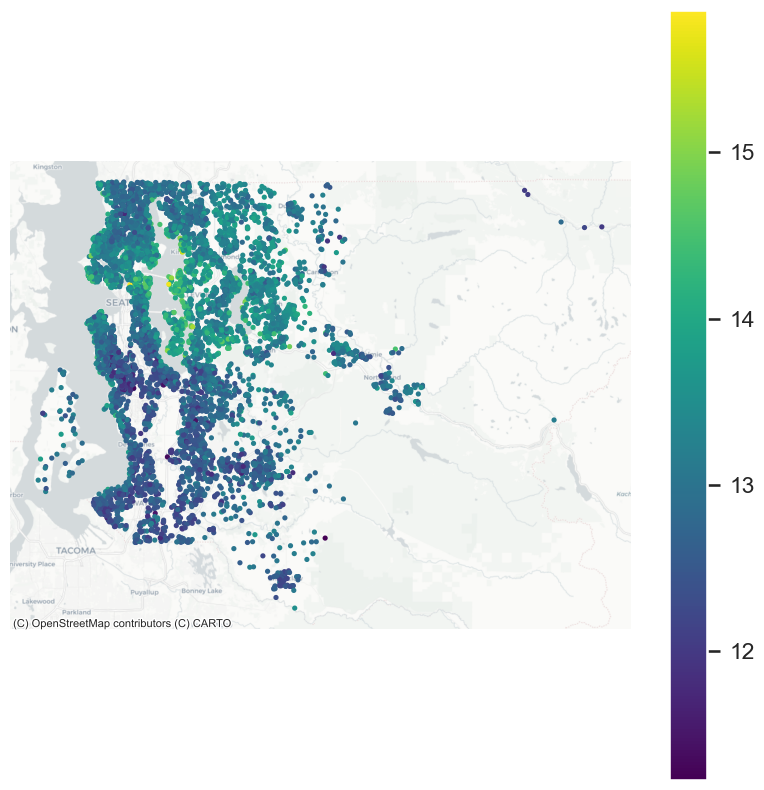

In [14]:
gdf = gpd.GeoDataFrame(
    train_df.copy(),
    geometry=gpd.points_from_xy(train_df[LON_COL], train_df[LAT_COL]),
    crs="EPSG:4326",
)

gdf_web = gdf.to_crs(epsg=3857)

sample = gdf_web.sample(min(8000, len(gdf_web)), random_state=42)

fig, ax = plt.subplots(figsize=(10,10))
sample.plot(
    ax=ax,
    column="log_price",
    cmap="viridis",
    markersize=5,
    legend=True
)

ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.axis("off")
plt.show()


VISUAL EDA

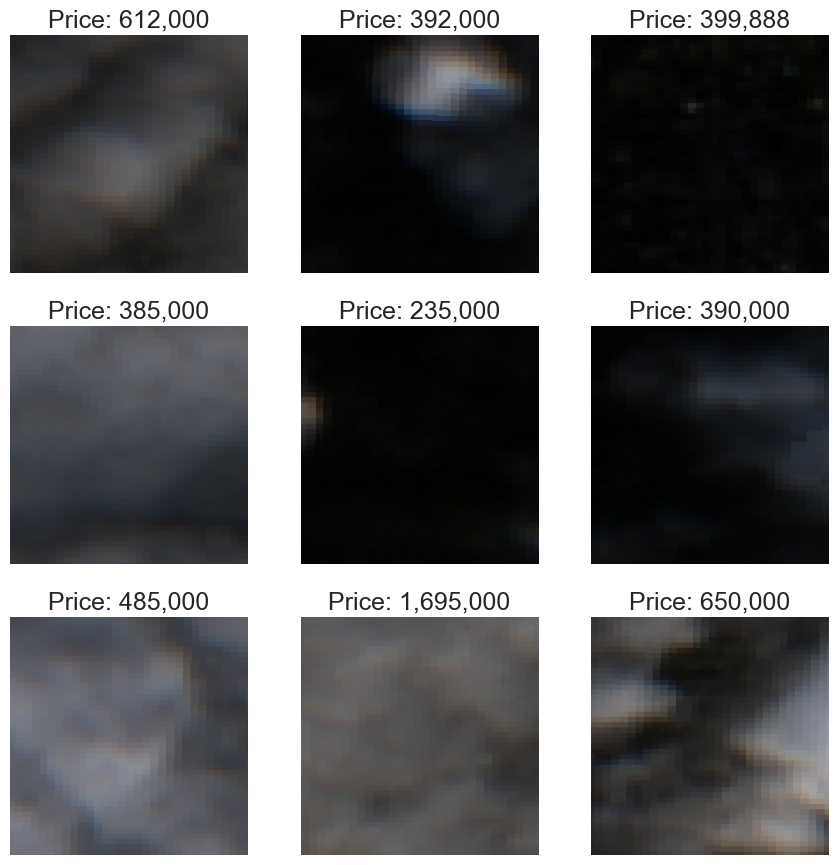

In [15]:
def show_random_images(n=9):
    sample = train_df[train_df["image_exists"]].sample(n, random_state=42)
    fig, axes = plt.subplots(3, 3, figsize=(9,9))
    axes = axes.flatten()

    for ax, (_, row) in zip(axes, sample.iterrows()):
        img = Image.open(row["image_path"]).convert("RGB")
        ax.imshow(img)
        ax.set_title(f"Price: {row[TARGET_COL]:,.0f}")
        ax.axis("off")

    plt.tight_layout()
    plt.show()

show_random_images()


CREATE SPATIAL BINS

In [16]:
grid_size = 0.02

lat_bin = (train_df[LAT_COL] / grid_size).round().astype(int)
lon_bin = (train_df[LON_COL] / grid_size).round().astype(int)

train_df["spatial_bin"] = lat_bin.astype(str) + "_" + lon_bin.astype(str)

train_df["spatial_bin"].nunique()


687

TRAIN / VAL SPLIT

In [17]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

train_idx, val_idx = next(
    gss.split(train_df, groups=train_df["spatial_bin"])
)

train_split = train_df.iloc[train_idx].copy()
val_split = train_df.iloc[val_idx].copy()

print("Train:", train_split.shape)
print("Val:", val_split.shape)


Train: (13334, 25)
Val: (2875, 25)


In [18]:
train_split = train_split[train_split["image_exists"]]
val_split = val_split[val_split["image_exists"]]

print("Final Train:", train_split.shape)
print("Final Val:", val_split.shape)


Final Train: (13334, 25)
Final Val: (2875, 25)


SAVE FINAL DATA

In [20]:
train_split.to_csv(PROCESSED_DIR / "train_final.csv", index=False)
val_split.to_csv(PROCESSED_DIR / "val_final.csv", index=False)

print("Preprocessing complete ✅ (saved as CSV)")


Preprocessing complete ✅ (saved as CSV)


In [21]:
import os

files = os.listdir("data/images")
print(files[:20])
print("Total images:", len(files))


['3975.png', '8820.png', '14392.png', '9280.png', '348.png', '15932.png', '12085.png', '1804.png', '10692.png', '11598.png', '4968.png', '10686.png', '9294.png', '15926.png', '12091.png', '1810.png', '15098.png', '6819.png', '8834.png', '14386.png']
Total images: 16209


In [22]:
import pandas as pd
import os

df = pd.read_csv("train(1)(train(1)).csv")

IMAGE_DIR = "data/images"
metadata = []

for idx, row in df.iterrows():
    img_file = f"{idx}.png"
    img_path = os.path.join(IMAGE_DIR, img_file)

    if os.path.exists(img_path):
        metadata.append({
            "id": row["id"],              # ✅ correct house ID
            "image_path": img_path,       # ✅ existing image
            "status": "ok"
        })

meta_df = pd.DataFrame(metadata)

os.makedirs("data/satellite", exist_ok=True)
meta_df.to_csv("data/satellite/image_metadata.csv", index=False)

print("✅ image_metadata.csv created")
print(meta_df.head())
print("Total linked images:", len(meta_df))


✅ image_metadata.csv created
           id         image_path status
0  9117000170  data/images/0.png     ok
1  6700390210  data/images/1.png     ok
2  7212660540  data/images/2.png     ok
3  8562780200  data/images/3.png     ok
4  7760400350  data/images/4.png     ok
Total linked images: 16209


In [23]:
meta_df = pd.read_csv("data/satellite/image_metadata.csv")

print(meta_df.head())
print("Images found:", meta_df["image_path"].apply(os.path.exists).sum())


           id         image_path status
0  9117000170  data/images/0.png     ok
1  6700390210  data/images/1.png     ok
2  7212660540  data/images/2.png     ok
3  8562780200  data/images/3.png     ok
4  7760400350  data/images/4.png     ok
Images found: 16209


In [25]:
meta_df = pd.read_csv("data/satellite/image_metadata.csv")
